# 1. Required libraries

In [1]:
import datetime
import feature_engg as engg
import feature_util as utl
import feature_viz as viz
import gc
import gpxpy.geo
import graphviz 
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import grid_search
from sklearn import metrics
from sklearn import tree
from sklearn import linear_model
from sklearn import model_selection
import warnings

warnings.filterwarnings('ignore')

C:\Users\310195644\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\310195644\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 2. Load data

Load all four datasets + city data (contains city name, latitude, longitude).

In [2]:
# cities
df_cities = pd.read_csv('../data/world_cities.txt', sep=",", encoding='latin1')
df_cities = df_cities[['country', 'city', 'accent_city', 'lat', 'lon']]
df_cities['accent_city'] = df_cities.accent_city.str.lower()

# events
df_events = utl.get_df('../data/events.json', encoding='latin1')
df_events.columns = ['e_' + str(col) for col in df_events.columns]

# groups
df_groups = utl.get_df('../data/groups.json', encoding='utf-8')
df_groups.columns = ['g_' + str(col) for col in df_groups.columns]

# users
df_users = utl.get_df('../data/users.json', encoding='utf-8')
df_users['city'] = df_users.city.str.lower()

# venues
df_venues = utl.get_df('../data/venues.json', encoding='utf-8')
df_venues['city'] = df_venues.city.str.lower()
df_venues.columns = ['v_' + str(col) for col in df_venues.columns]

<type 'list'>
<type 'list'>
<type 'list'>
<type 'list'>


Join city data with user data to get user city latitude and longitude.

In [3]:
df_users = df_users.sort(['user_id'], ascending=[1])
df_users = df_users.merge(df_cities, left_on=['country', 'city'], right_on=['country', 'accent_city'], how='left')
df_users = df_users.drop_duplicates(subset=['user_id'], keep='first')
df_users.columns = ['u_' + str(col)  for col in df_users.columns]

# 3. Features

## 3.1 Event attributes

In [4]:
df_events.describe()

,e_venue_id,e_rsvp_limit,e_created,e_time,e_duration
count,6200.000000,2211.000000,6.200000e+03,6.183000e+03,2.600000e+03
mean,67959.885484,47.700588,1.386568e+12,1.395698e+12,2.411515e+07
std,488.481235,42.778604,4.081886e+10,3.952652e+10,6.576107e+07
min,67082.000000,1.000000,1.172849e+12,1.173946e+12,2.700000e+06
25%,67563.000000,20.000000,1.361802e+12,1.371807e+12,7.200000e+06
50%,67951.000000,40.000000,1.393498e+12,1.404758e+12,1.080000e+07
75%,68345.000000,60.000000,1.420825e+12,1.427378e+12,1.620000e+07
max,68812.000000,500.000000,1.440671e+12,1.472015e+12,1.148400e+09


Based on event timestamps calculate event hour of day, day of week and duration for event sign up.

In [5]:
df_events = df_events.assign(e_event_id=[i+1 for i in xrange(len(df_events))])
df_events = df_events[df_events.e_time.notnull()]
df_events['e_datetime'] = pd.to_datetime((df_events['e_time']/1000).astype(int), unit='s')
df_events['e_hour'] = df_events.e_datetime.dt.hour
df_events['e_dow'] = df_events.e_datetime.dt.dayofweek
df_events['e_reg_hours'] = (df_events.e_time - df_events.e_created) / 3600000

## 3.2 Group attributes

In [6]:
df_groups.describe()

,g_created,g_lon,g_lat
count,7.110000e+02,711.000000,711.000000
mean,1.394015e+12,5.269170,51.965724
std,4.303401e+10,0.889074,0.572717
min,1.172849e+12,3.130000,50.930000
25%,1.372933e+12,4.890000,51.439999
50%,1.407404e+12,4.890000,52.099998
75%,1.426360e+12,5.470000,52.369999
max,1.440612e+12,7.200000,53.230000


## 3.3 User attributes

In [7]:
df_users.describe()

,u_user_id,u_lat,u_lon
count,57773.000000,57192.000000,57192.000000
mean,38193.992955,50.538063,3.663417
std,16678.304214,8.266970,22.023226
min,9307.000000,-43.533333,-170.275000
25%,23751.000000,51.481431,4.500000
50%,38194.000000,52.093813,4.916667
75%,52637.000000,52.350000,5.389526
max,67081.000000,64.200000,174.783333


In [8]:
df_users = df_users[df_users.u_lat.notnull()]

## 3.4 Venue attributes

In [9]:
df_venues.describe()

,v_venue_id,v_lon,v_lat
count,1732.00000,1731.000000,1731.000000
mean,67947.50000,4.626416,50.060030
std,500.12965,8.932724,9.779613
min,67082.00000,-122.655571,-33.865340
25%,67514.75000,4.489095,51.447849
50%,67947.50000,4.896400,52.092468
75%,68380.25000,5.277729,52.366380
max,68813.00000,151.206670,59.327885


In [10]:
df_venues = df_venues[df_venues.v_lat.notnull()]

## 3.5 Feature engineering

In [11]:
print 'df_events shape: ', df_events.shape
print 'df_events columns: ', df_events.columns

df_events shape:  (6183, 15)
df_events columns:  Index([u'e_status', u'e_venue_id', u'e_description', u'e_rsvps',
       u'e_rsvp_limit', u'e_created', u'e_time', u'e_duration', u'e_group_id',
       u'e_name', u'e_event_id', u'e_datetime', u'e_hour', u'e_dow',
       u'e_reg_hours'],
      dtype='object')


In [12]:
df_events = df_events.merge(df_venues, left_on='e_venue_id', right_on='v_venue_id', how='left')
df_events = df_events.merge(df_groups, left_on='e_group_id', right_on='g_group_id', how='left')
del df_events['v_venue_id'], df_events['g_group_id']

In [13]:
df_events_flat = utl.flatten_list(df_events, 'e_rsvps', reset_index=True)
df_events_flat = utl.flatten_dict(df_events_flat, 'e_rsvps')
df_events_flat['e_response_num'] = df_events_flat.response.apply(lambda x: engg.label_attendance(x))
df_events_flat['e_total_attend'] = df_events_flat.e_response_num + df_events_flat.guests
df_events_flat = df_events_flat.merge(df_users, left_on='user_id', right_on='u_user_id', how='left')
df_events_flat = df_events_flat[df_events_flat.u_user_id.notnull()]
del df_events_flat['u_user_id']

In [ ]:
# n_events_peruser = df_events_flat.groupby(['user_id']).agg({'label': 'sum'}).reset_index()
# print 'Total attendance: \n', df_events_flat.total_att.describe()
# print '\nResponse summary: \n', df_events_flat.response.value_counts()
# print '\nGuest count summary: \n', df_events_flat.guests.describe()
# print 'Number of events attended per user: \n', n_events_peruser.label.describe()
# print '\nStatus of events:\n', df_events_flat.status.value_counts()

In [14]:
df_events_flat['vu_dist'] = df_events_flat.apply(lambda row: gpxpy.geo.haversine_distance(row['v_lat'], row['v_lon'], 
                                                                                          row['u_lat'], row['u_lon']), axis=1)
df_events_flat['vg_dist'] = df_events_flat.apply(lambda row: gpxpy.geo.haversine_distance(row['v_lat'], row['v_lon'], 
                                                                                          row['g_lat'], row['g_lon']), axis=1)
df_events_flat['group_tenure'] = (df_events_flat.e_time - df_events_flat.g_created) / 86400000

In [15]:
df_memberships = df_events_flat.groupby('user_id').agg(lambda x: x.iloc[0]).reset_index()
df_memberships = utl.flatten_list(df_memberships, 'u_memberships', reset_index=True)
df_memberships = df_memberships[['user_id', 'u_memberships']]
df_memberships = utl.flatten_dict(df_memberships, 'u_memberships')
df_memberships.columns = ['m_' + str(col) for col in df_memberships.columns]

In [16]:
df_events_flat = df_events_flat.merge(df_memberships, left_on=['user_id', 'e_group_id'], right_on=['m_user_id', 'm_group_id'],
                                    how='left')
df_events_flat['group_member_tenure'] = (df_events_flat.e_time - df_events_flat.m_joined) / 86400000
del df_events_flat['u_memberships'], df_events_flat['m_user_id'], df_events_flat['m_group_id']

In [18]:
df_group_events = df_events_flat[['e_event_id', 'e_time', 'e_group_id']]
df_group_events = df_group_events.drop_duplicates(subset='e_event_id', keep='first')
df_group_events['g_past_events'] = df_group_events.e_event_id.apply(lambda x: engg.count_past_group_events(df_group_events, x))
df_user_events = df_events_flat[['e_event_id', 'e_time', 'user_id']]
df_user_events = df_user_events.drop_duplicates(subset=['e_event_id', 'user_id'], keep='first')
df_user_events['u_past_events'] = df_user_events.apply(lambda row: engg.count_past_user_events(df_user_events, row.user_id, row.e_event_id), 1)
df_events_flat = df_events_flat.merge(df_group_events, on='e_event_id', how='left')
df_events_flat = df_events_flat.merge(df_user_events, on=['e_event_id', 'user_id'], how='left')
del df_events_flat['e_time_y'], df_events_flat['e_group_id_y']

# 4. Generate training data

In [38]:
df_agg = df_events_flat.groupby(['e_event_id', 'e_hour', 'e_dow', 'e_reg_hours']) \
                       .agg({'vu_dist' : 'median',
                             'vg_dist':'median', 
                             'group_tenure': 'mean',
                             'group_member_tenure': 'mean',
                             'g_past_events': 'mean',
                             'u_past_events': 'median',
                             'e_total_attend' : 'sum'}).reset_index()
# df_agg['e_hour_1'] = np.where(np.logical_or(df_agg.e_hour<=2, df_agg.e_hour > 22), 1, 0)
df_agg['e_hour_2'] = np.where(np.logical_and(df_agg.e_hour>2, df_agg.e_hour <= 6), 1, 0)
df_agg['e_hour_3'] = np.where(np.logical_and(df_agg.e_hour>6, df_agg.e_hour <= 10), 1, 0)
df_agg['e_hour_4'] = np.where(np.logical_and(df_agg.e_hour>10, df_agg.e_hour <= 14), 1, 0)
df_agg['e_hour_5'] = np.where(np.logical_and(df_agg.e_hour>14, df_agg.e_hour <= 18), 1, 0)
df_agg['e_hour_6'] = np.where(np.logical_and(df_agg.e_hour>18, df_agg.e_hour <= 22), 1, 0)
df_agg['e_day_1'] = np.where(df_agg.e_dow==1, 1, 0)
df_agg['e_day_2'] = np.where(df_agg.e_dow==2, 1, 0)
df_agg['e_day_3'] = np.where(df_agg.e_dow==3, 1, 0)
df_agg['e_day_4'] = np.where(df_agg.e_dow==4, 1, 0)
df_agg['e_day_5'] = np.where(df_agg.e_dow==5, 1, 0)
df_agg['e_day_6'] = np.where(df_agg.e_dow==6, 1, 0)
# df_agg['e_day_7'] = np.where(df_agg.e_dow==7, 1, 0)
df_agg = df_agg.dropna(axis=0, how='any')
df_data = df_agg.drop(['e_event_id', 'e_hour', 'e_dow'], axis=1)

In [39]:
print 'Venue and user distance quantile 96%: ', df_data.vu_dist.quantile(.96)
print 'Venue and group distance quantile 96%: ', df_data.vg_dist.quantile(.96)

Venue and user distance quantile 96%:  357576.367333
Venue and group distance quantile 96%:  151688.495304


In [ ]:
df_data = df_data[df_data.vu_dist < df_data.vu_dist.quantile(.96)]
df_data = df_data[df_data.vg_dist < df_data.vg_dist.quantile(.96)]

In [40]:
df_data.corr(method='pearson')

,e_reg_hours,vg_dist,u_past_events,e_total_attend,vu_dist,group_member_tenure,g_past_events,group_tenure,e_hour_2,e_hour_3,e_hour_4,e_hour_5,e_hour_6,e_day_1,e_day_2,e_day_3,e_day_4,e_day_5,e_day_6
e_reg_hours,1.000000,0.040306,-0.033985,0.081116,0.037938,0.387771,-0.040089,0.468759,0.046128,0.068993,-0.083357,-0.003442,-0.018925,-0.068786,0.108437,0.051570,-0.055583,-0.049987,-0.035245
vg_dist,0.040306,1.000000,0.059218,-0.059773,0.862246,-0.025828,-0.044086,-0.052035,0.074860,0.163646,-0.042748,-0.115382,-0.025775,-0.016267,-0.052566,-0.027788,-0.016895,0.216612,-0.025224
u_past_events,-0.033985,0.059218,1.000000,-0.245946,0.063746,0.084715,0.595966,-0.006933,-0.024363,0.128477,0.078586,-0.167367,0.049327,-0.044823,0.074799,-0.186600,-0.009145,0.167578,0.044480
e_total_attend,0.081116,-0.059773,-0.245946,1.000000,-0.071672,-0.024804,-0.164396,0.155013,0.004798,-0.054408,-0.064408,0.098427,-0.033624,-0.030710,-0.038799,0.150126,-0.017434,-0.090427,-0.046780
vu_dist,0.037938,0.862246,0.063746,-0.071672,1.000000,-0.015694,-0.049461,-0.055231,0.048369,0.148943,-0.041485,-0.094623,-0.024236,-0.014668,-0.061755,-0.020961,-0.007502,0.214397,-0.027044
group_member_tenure,0.387771,-0.025828,0.084715,-0.024804,-0.015694,1.000000,0.134274,0.758655,0.071260,0.117744,0.000447,-0.120221,0.016121,-0.030190,0.028568,-0.043166,-0.015898,0.073103,-0.013389
g_past_events,-0.040089,-0.044086,0.595966,-0.164396,-0.049461,0.134274,1.000000,0.147757,-0.028853,0.188225,0.145611,-0.244001,0.014605,-0.093594,0.226349,-0.210256,-0.067848,0.174699,0.044244
group_tenure,0.468759,-0.052035,-0.006933,0.155013,-0.055231,0.758655,0.147757,1.000000,0.113091,0.186982,-0.010767,-0.164710,-0.017399,-0.059830,0.059565,0.036447,-0.051108,0.047947,-0.009223
e_hour_2,0.046128,0.074860,-0.024363,0.004798,0.048369,0.071260,-0.028853,0.113091,1.000000,-0.058189,-0.046170,-0.187943,-0.024119,-0.025445,-0.053559,0.114687,-0.009888,-0.007599,-0.018727
e_hour_3,0.068993,0.163646,0.128477,-0.054408,0.148943,0.117744,0.188225,0.186982,-0.058189,1.000000,-0.156907,-0.638712,-0.081967,-0.144801,-0.047517,-0.077785,0.002129,0.446298,0.076248


In [41]:
df_data_1 = df_data[df_data.g_past_events == 0]
del df_data_1['g_past_events']
df_data_2 = df_data[df_data.g_past_events > 0]

In [42]:
X = df_data.drop('e_total_attend', axis=1)
Y = df_data.e_total_attend
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=999)
# X.corr(method='pearson')

X_1 = df_data_1.drop('e_total_attend', axis=1)
Y_1 = df_data_1.e_total_attend
X_train_1, X_test_1, y_train_1, y_test_1 = model_selection.train_test_split(X_1, Y_1, test_size=0.2, random_state=999)
# X_1.corr(method='pearson')

X_2 = df_data_2.drop('e_total_attend', axis=1)
Y_2 = df_data_2.e_total_attend
X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(X_2, Y_2, test_size=0.2, random_state=999)
# X_2.corr(method='pearson')

In [27]:
var_names = ['e_reg_hours', 'u_past_events', 'vg_dist', 'vu_dist', 'group_member_tenure', 'group_tenure']
viz.generate_plot(df_data, '', var_names)
viz.generate_plot(df_data_1, '1', var_names)
viz.generate_plot(df_data_2, '2', var_names)

# 5. Model building

## 5.1 Regression

In [43]:
lm = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=False)
lm.fit(X=X_train_2, y=y_train_2)
# scores = model_selection.cross_val_score(lm, X_train, y_train, cv=5)
# print scores
# y_test_pred = model_selection.cross_val_predict(lm, X_test, y_test, cv=5)
y_test_pred = lm.predict(X_test_2)
print 'R2 score for the linear regression model is:', metrics.r2_score(y_test_2, y_test_pred)

R2 score for the linear regression model is: 0.165969272842


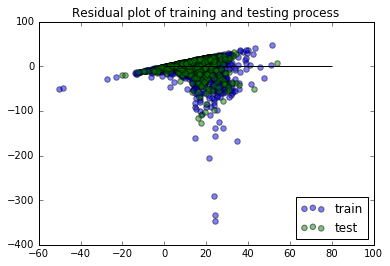

In [44]:
y_train_pred = lm.predict(X_train_2)
plt.scatter(y_train_pred, y_train_pred-y_train_2, c='b', s=30, alpha=0.5, label='train')
plt.scatter(y_test_pred, y_test_pred-y_test_2, c='g', s=30, alpha=0.5, label='test')
plt.hlines(y=0, xmin=0, xmax=80)
plt.legend(loc='lower right')
plt.title('Residual plot of training and testing process')
plt.show()

## 4.2 Decision tree

In [51]:
param_grid = {"min_samples_split": [45, 80, 120],
              "max_depth": [2, 4, 7, 10],
              "min_samples_leaf": [45, 80, 120],
              "max_leaf_nodes": [4, 12, 20]}

dt = tree.DecisionTreeRegressor()
g_search = grid_search.GridSearchCV(dt, param_grid=param_grid, cv=5)
g_search.fit(X_train_2, y_train_2)
best_params = g_search.best_params_
print 'Best parameters for decision tree: ', best_params

Best parameters for decision tree:  {'min_samples_split': 120, 'max_leaf_nodes': 20, 'max_depth': 7, 'min_samples_leaf': 45}


In [52]:
dt_2 = tree.DecisionTreeRegressor(max_depth=4, min_samples_leaf=45)
dt_2.fit(X_train_2, y_train_2)
y_test_pred = dt_2.predict(X_test_2)

In [53]:
df_feature_imp = pd.DataFrame({'Name': X_train_2.columns, 'Importance': dt_2.feature_importances_})

In [54]:
print df_feature_imp

    Importance                 Name
0     0.050622          e_reg_hours
1     0.126444              vg_dist
2     0.567380        u_past_events
3     0.096220              vu_dist
4     0.000000  group_member_tenure
5     0.016673        g_past_events
6     0.115336         group_tenure
7     0.000000             e_hour_2
8     0.000000             e_hour_3
9     0.000000             e_hour_4
10    0.027326             e_hour_5
11    0.000000             e_hour_6
12    0.000000              e_day_1
13    0.000000              e_day_2
14    0.000000              e_day_3
15    0.000000              e_day_4
16    0.000000              e_day_5
17    0.000000              e_day_6


# 5. Export model

In [55]:
with open("../model/dt_model.txt", "w") as f:
    f = tree.export_graphviz(dt_2, out_file=f, feature_names=X_train.columns)